# snlpy demo

## CsrGraph

In [1]:
# Make sure you have the latest version of networkx
# First, we generate a SBM to train on. It has 5 blocks of size 20,
# and the average density within blocks is .7, while that between is .07
import networkx as nx
block_size = 20
block_number = 5
g = nx.generators.community.stochastic_block_model([block_size for _ in range(block_number)], [[.7 if i == j else .07 for j in range(block_number)] for i in range(block_number)])
#Now we will convert it to snlpy's CsrGraph format
import snlpy
g = snlpy.CsrGraph(g)

In [2]:
# Here's some stuff you can do with CsrGraph
# NOTE: CsrGraph is an immutable datatype
print('The sbm has %d nodes and %d edges.' % (g.number_of_nodes(), g.number_of_edges()))
print('Node 0 has %d neighbors.' % (len(g.neighbors(0))))

The sbm has 100 nodes and 938 edges.
Node 0 has 19 neighbors.


## Embeddings

In [3]:
# Let's generate some embeddings on g
dw_emb = snlpy.DeepWalk(g, dimensions=32)
nmf_emb = snlpy.NetMF(g, dimensions=32)
n2v_emb = snlpy.Node2Vec(g, dimensions=32)

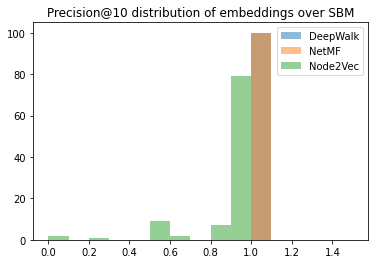

In [4]:
# Let's see how well the dot products approximate the block structure
# We'll calculate the precision at 10 for all methods
from sklearn.metrics import precision_recall_curve
import numpy as np
def p10_distribution(emb):
    ps = []
    for v in range(len(emb)):
        dot_products = np.dot(emb[v, :], emb.T)
        curr_block = v // block_size
        ps.append(np.sum([1 for u in np.argsort(-dot_products)[:10] if u // block_size == curr_block])/10)
    return ps

#They look pretty good!
import matplotlib.pyplot as plt
plt.hist(p10_distribution(dw_emb), alpha=.5, label='DeepWalk')
plt.hist(p10_distribution(nmf_emb), alpha=.5, label='NetMF')
plt.hist(p10_distribution(n2v_emb), alpha=.5, label='Node2Vec')
plt.legend()
plt.title('Precision@10 distribution of embeddings over SBM')
plt.show()

## PPR clustering

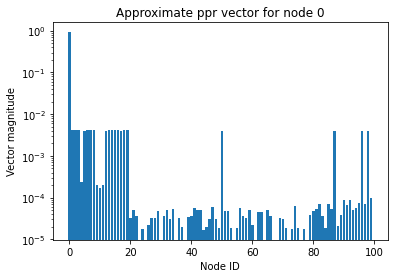

In [5]:
#Let's see what a ppr cluster looks like with 0 as a seed
#Almost all of the weight is on vertices in 0's block (the first 100).
#That's pretty cool, it means its a good way to get nodes in the same
#community as the seed.
ppr_vector = snlpy.ppr(g, [0], alpha=0.85, tol=0.000001)
plt.bar(range(g.number_of_nodes()), ppr_vector.toarray().reshape(-1,))
plt.yscale('log')
plt.title('Approximate ppr vector for node 0')
plt.xlabel('Node ID')
plt.ylabel('Vector magnitude')
plt.show()